## Feature importance and selection

Studen: Ivette Sulca

Report overview:
0. Introduction: Dataset
1. Direct techniques : Spearman correlation and mRMR
2. Model-based techniques: Drop column and Permutation importance
3. Comparison between techniques
4. Automatic feature selection
5. Variance analysis for feature importance


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn import preprocessing
from sklearn.utils import resample
import seaborn as sns
import xgboost as xgb
from rfpimp import plot_corr_heatmap
import shap

/Users/ivettesulca/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
%run featimp

## 0. Introduction: Dataset

For this report we will be using the Boston dataset of sklearn which has as target variable the price.
Based on the scatter on correlation plot, we can easily that the price has a strong relationship with LSTAT and RM, and also there is codependence between features since AGE for example is highly correlated with NOX and DIS. Therefore, this is an interesting dataset to analyze feature importance.

In [3]:
boston_dataset = load_boston()
boston = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
boston['PRICE'] = boston_dataset.target
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


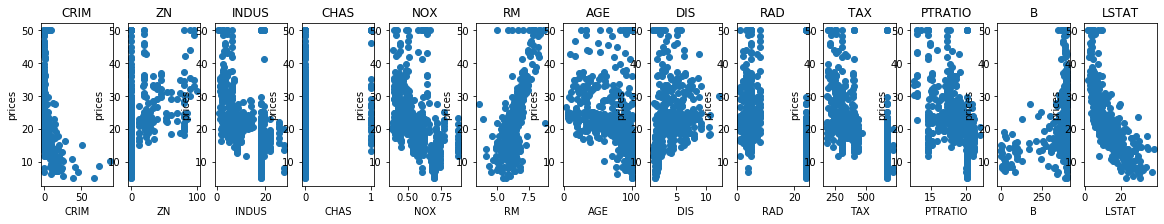

In [4]:
plt.figure(figsize=(20, 3))
for i, col in enumerate(boston.drop('PRICE', axis = 1).columns):
    plt.subplot(1, 13, i+1)
    x = boston[col]
    y = boston['PRICE']
    plt.plot(x, y, 'o')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('prices')

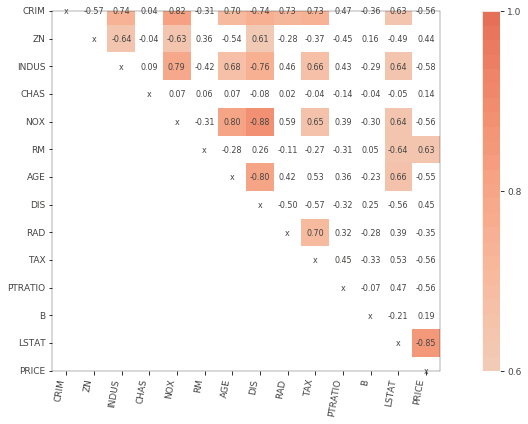

In [5]:
viz = plot_corr_heatmap(boston, figsize=(15,6))
viz.view()

In [6]:
X = boston.drop('PRICE', axis = 1)
y = boston['PRICE'].values

## 1. Direct techniques: Spearman correlation and mRMR

SPEARMAN'S RANK CORRELATION COEFFICIENT: We implement the function featureimp_spearman to calculate this coefficient which can assess individual relationships between our features and our target variable. The advantage of this technique, since it is based on a monotonic function, it can assess no linear relationships and it is not sensitive to outliers.
- Note: We are computing absolute values in the final spearman's coefficient to get the correct ranking.

Text(0.5, 0, 'Feature')

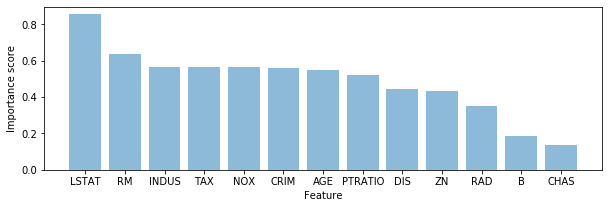

In [7]:
dict_import_spearman = featureimp_spearman(X,y)

plt.figure(figsize=(10, 3))
plt.bar(dict_import_spearman.keys(),list(dict_import_spearman.values()),align='center', alpha=0.5, capsize=7)
plt.ylabel('Importance score')
plt.xlabel('Feature')

mRMR(MAXIMUM RELEVANCE AND MINIMUM REDUNDANCY): It is considered one of the best techniques for feature importance currently. This technique measures the individual relationship between a feature and a target(maximizing relevance) but also to other set of features (minimizing redundancy) and use the difference between these two measures to get a final score. Also, to measure the relationship for this exercise we will consider the Spearman ranking coefficient.
- Note: Look how the ranking changes with respect to the Spearman's ranking coefficient! It suggests that only 5 features are relevant and the others are redundant for our prediction.

Text(0.5, 0, 'Feature')

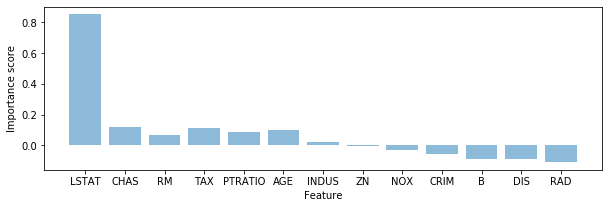

In [8]:
dict_import_mrmr = featureimp_mrmr(X,y,1)

plt.figure(figsize=(10, 3))
plt.bar(dict_import_mrmr.keys(),list(dict_import_mrmr.values()),align='center', alpha=0.5, ecolor='orange', capsize=7)
plt.ylabel('Importance score')
plt.xlabel('Feature')

## 2. Model-based techniques: drop column and permutation importance

Drop columns and permutation importance can help us explain how important is a variable for an specific model. In the next example we will train a Random Forest and compare both strategies.

In [9]:
# Random Forest model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=10)
model_rf = RandomForestRegressor(min_samples_leaf=6,n_estimators = 200,random_state=0,oob_score=True)

DROP COLUMN: This technique drops a column and retrains the model to compare the new metric of our validation dataset with our initial baseline metric. The drop on the metric is how important the columns is for the model. In this case we will use MSE.

Text(0.5, 0, 'Feature')

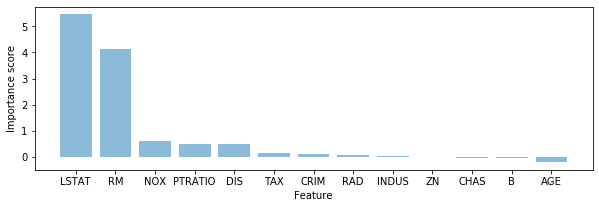

In [10]:
dict_import_drop = featureimp_dropcolumn(model_rf,X_train, y_train,X_val,y_val)

plt.figure(figsize=(10, 3))
plt.bar(dict_import_drop.keys(),list(dict_import_drop.values()),align='center', alpha=0.5, ecolor='orange', capsize=7)
plt.ylabel('Importance score')
plt.xlabel('Feature')

PERMUTATION IMPORTANCE: This technique doesn't need to retrain the model, instead, it needs to permute each one of the features on validation set based on a previous model and then measure the drop on the metric. For this particular dataset, we don't much change on the results.

Text(0.5, 0, 'Feature')

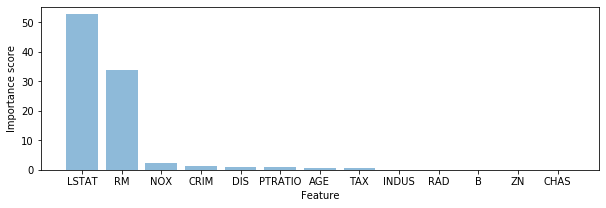

In [11]:
dict_import_permut = featureimp_permutation(model_rf,X_train, y_train,X_val,y_val)

plt.figure(figsize=(10, 3))
plt.bar(dict_import_permut.keys(),list(dict_import_permut.values()),align='center', alpha=0.5, ecolor='orange', capsize=7)
plt.ylabel('Importance score')
plt.xlabel('Feature')

## 3. Comparison between techniques

First, we will add SHAP values as an additional feature importance method based on Game Theory. Our baseline model will be an XGBoost model

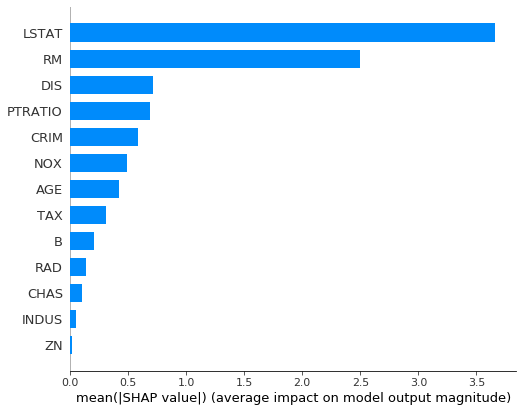

In [12]:
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',learning_rate = 0.01,n_estimators = 1000)
model_xgb.fit(X_train,y_train)
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar")

dict_import_shap = {'LSTAT':13,'RM':12, 'DIS':11,'PTRATIO':10,'CRIM':9,
                    'NOX':8,'AGE':7,'TAX':6,'B':5,'RAD':4,'CHAS':3,'INDUS':2,'ZN':1}

EXPERIMENT WITH XGBOOST: Using Spearman's coefficient and mRMR on an XGBoost model, we see that mRMR doesn't help reducing the number of minimum features, but SHAP values outpermorfs between the three methods since it gets the least MSE for this particular model.

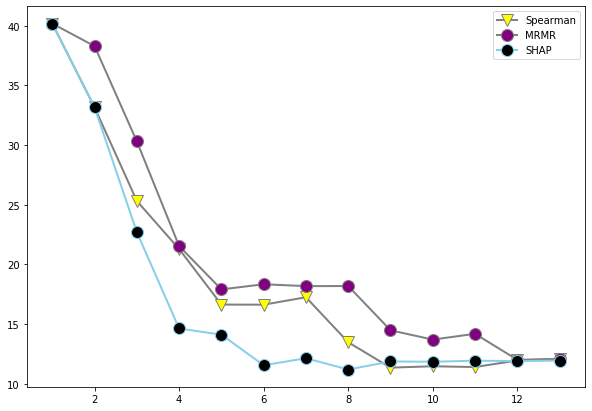

In [13]:
k = X.shape[1]
list_scores = []
list_imp = [dict_import_spearman,dict_import_mrmr,dict_import_shap]
name_imp = ['Spearman','MRMR','SHAP']
for i in range(k):    
    for j,dict_imp in enumerate(list_imp):
        top_k_feat = list(dict_imp.keys())[:(i+1)]        
        model_xgb = xgb.XGBRegressor(objective='reg:squarederror',learning_rate = 0.01,n_estimators = 1000)
        model_xgb.fit(X_train[top_k_feat],y_train)

        y_pred = model_xgb.predict(X_val[top_k_feat])    
        metric = mean_squared_error(y_val, y_pred)
        list_scores.append([name_imp[j],i+1,metric])

df_bench = pd.DataFrame(list_scores)
df_bench.columns = ['method','n_feature','MSE']

plt.figure(figsize=(10,7)) 
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='Spearman'],label="Spearman", marker='v', markerfacecolor='yellow', markersize=12, color='grey', linewidth=2)
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='MRMR'], label="MRMR",marker='o', markerfacecolor='purple', markersize=12, color='grey', linewidth=2)
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='SHAP'], label="SHAP",marker='o', markerfacecolor='black', markersize=12, color='skyblue', linewidth=2)
plt.legend()

EXPERIMENT WITH RANDOMFOREST: For Random Forest we observe that MRMR and Spearman get very similar results unlike XGBoost and Linear Regression.

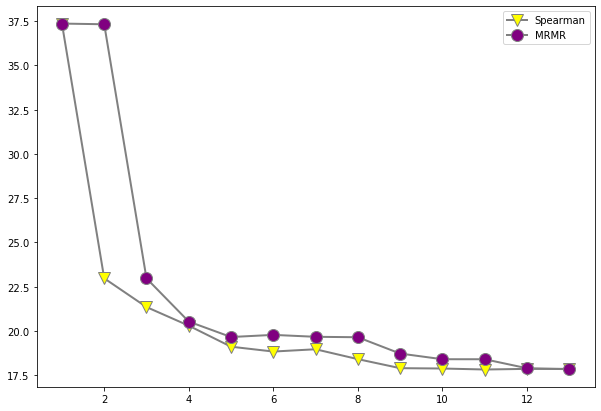

In [14]:
k = X.shape[1]
list_scores = []
list_imp = [dict_import_spearman,dict_import_mrmr]
name_imp = ['Spearman','MRMR']
for i in range(k):    
    for j,dict_imp in enumerate(list_imp):
        top_k_feat = list(dict_imp.keys())[:(i+1)]        
        model_xgb = RandomForestRegressor(min_samples_leaf=6,n_estimators = 200,random_state=0,oob_score=True)
        model_xgb.fit(X_train[top_k_feat],y_train)

        y_pred = model_xgb.predict(X_val[top_k_feat])    
        metric = mean_squared_error(y_val, y_pred)
        list_scores.append([name_imp[j],i+1,metric])

df_bench = pd.DataFrame(list_scores)
df_bench.columns = ['method','n_feature','MSE']

plt.figure(figsize=(10,7)) 
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='Spearman'],label="Spearman", marker='v', markerfacecolor='yellow', markersize=12, color='grey', linewidth=2)
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='MRMR'], label="MRMR",marker='o', markerfacecolor='purple', markersize=12, color='grey', linewidth=2)

plt.legend()

LINEAR REGRESSION: Using Spearman's coefficient and mRMR on an basic linear model, we see that mRMR outperforms at ranking the most important features.

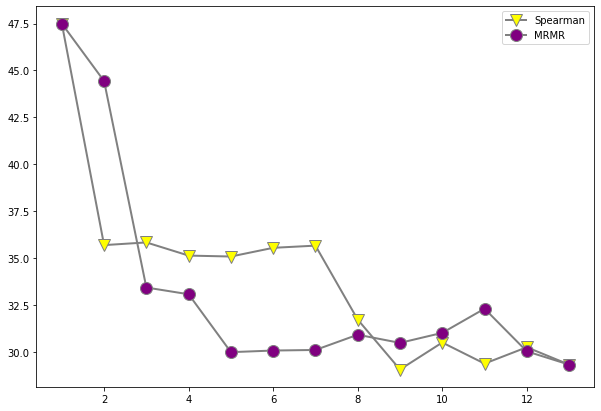

In [66]:
k = X.shape[1]
list_scores = []
list_imp = [dict_import_spearman,dict_import_mrmr]
name_imp = ['Spearman','MRMR']
for i in range(k):    
    for j,dict_imp in enumerate(list_imp):
        top_k_feat = list(dict_imp.keys())[:(i+1)]        
        model = LinearRegression()
        model.fit(X_train[top_k_feat],y_train)

        y_pred = model.predict(X_val[top_k_feat])    
        metric = mean_squared_error(y_val, y_pred)
        list_scores.append([name_imp[j],i+1,metric])

df_bench = pd.DataFrame(list_scores)
df_bench.columns = ['method','n_feature','MSE']

plt.figure(figsize=(10,7)) 
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='Spearman'],label="Spearman", marker='v', markerfacecolor='yellow', markersize=12, color='grey', linewidth=2)
plt.plot( 'n_feature', 'MSE', data=df_bench.loc[df_bench.method=='MRMR'], label="MRMR",marker='o', markerfacecolor='purple', markersize=12, color='grey', linewidth=2)
plt.legend()

## 4. Automatic feature selection

Let's use MRMR to help us decide the best features for our model. First, we get a baseline metric and then we start dropping the least important features and comparing with the baseline. In this exercise we are defining a THRESHOLD with respect to the baseline metric to decide the best k features.

In [16]:
# Threshold with respect to the baseline metric
threshold = 2

dict_import_mrmr = featureimp_mrmr(X_train,y_train,1)
dict_import_mrmr

k = X.shape[1]

X_train_n=X_train.copy()
y_train_n = y_train.copy()
X_val_n= X_val.copy()
y_val_n = y_val.copy()

list_mse = []
list_cols_dropped = []

model = RandomForestRegressor(min_samples_leaf=6,n_estimators = 200,random_state=0,oob_score=True)
#model = LinearRegression()
model.fit(X_train[top_k_feat],y_train)

y_pred = model.predict(X_val[top_k_feat])    
baseline_metric = mean_squared_error(y_val, y_pred)

print("*******Baseline metric(MSE):",baseline_metric)

print("*******Process:")
for i in range(1,k):
    
    dict_import_mrmr = featureimp_mrmr(X.drop(list_cols_dropped,axis=1),y,1)     
    worst_feature = list(dict_import_mrmr.keys())[-1]
    X_train_n=X_train_n.drop(worst_feature,axis=1)
    X_val_n=X_val_n.drop(worst_feature,axis=1)
    
    model.fit(X_train_n,y_train)

    y_pred = model.predict(X_val_n)    
    metric = mean_squared_error(y_val, y_pred)
    
    
    if abs(metric-baseline_metric)>=threshold: 
        break;

    list_mse.append([i,worst_feature,metric])
    list_cols_dropped.append(worst_feature)
    

df_report_drop = pd.DataFrame(list_mse)
df_report_drop.columns=['n_iteration','Column_dropped','New_MSE_after_dropping']
print(df_report_drop)
print("*******Final metric(MSE)",metric)
print("*******Selecting k=:",k-len(list_cols_dropped),"features")        
print("Features selected",set(X_train.columns) - set(list_cols_dropped))        


*******Baseline metric(MSE): 17.855113415024892
*******Process:
   n_iteration Column_dropped  New_MSE_after_dropping
0            1            RAD               17.924988
1            2            DIS               18.402576
2            3              B               18.410496
3            4           CRIM               18.728682
4            5          INDUS               18.753425
5            6             ZN               18.765472
6            7            NOX               19.786449
7            8           CHAS               19.785839
8            9            AGE               19.663996
*******Final metric(MSE) 20.535728827965702
*******Selecting k=: 4 features
Features selected {'LSTAT', 'TAX', 'PTRATIO', 'RM'}


## 5. Variance analysis for feature importance

We bootstrap our original dataset and calculate feature importance (based on mrmr technique) to get a distribution of feature importance scores calculating the mean and standard deviation for the final ranking. Here, we ensure with more confidence that RM, LSTAT and PRATIO have a strong relationship with the target, while the other features may vary in ranking order.

In [60]:
for n_exp in range(100):
    # bootstrapping
    X_res, y_res = resample(X,y,replace=True)
    dict_import_mrmr = featureimp_mrmr(X_res,y_res,1)     
    df_boot = pd.DataFrame(list(dict_import_mrmr.items()))
    
    if n_exp==0:
        df_total = pd.DataFrame(list(dict_import_mrmr.items()))        
    else:
        df_total = pd.concat([df_total,df_boot],axis=0)

df_total.columns = ['feature','importance_score']        

# Normalizing scores
min_max_scaler = preprocessing.MinMaxScaler()
df_total['importance_score'] = min_max_scaler.fit_transform(np.array(df_total.importance_score.values).reshape(-1,1))

# Calculating mean, variance and std
df_total=df_total.groupby(['feature']).agg({'importance_score':['mean','std','var']}).reset_index()
df_total.columns=['feature','mean','std','var']

df_total=df_total.sort_values('mean',ascending=False)
df_total.head(5)


,feature,mean,std,var
10,RM,0.880054,0.046719,0.002183
6,LSTAT,0.834068,0.035415,0.001254
8,PTRATIO,0.587825,0.044829,0.002010
11,TAX,0.348608,0.050173,0.002517
0,AGE,0.321513,0.051364,0.002638


Text(0.5, 0, 'Feature')

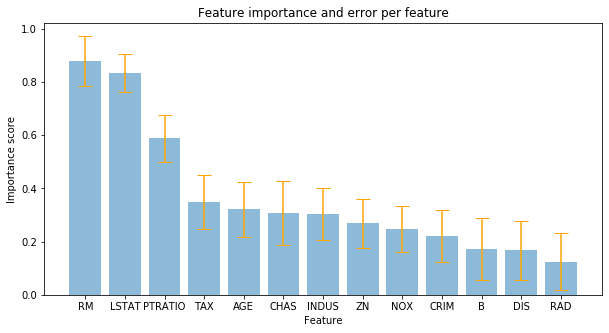

In [61]:
# Plotting results
plt.figure(figsize=(10, 5))
plt.bar(df_total['feature'],np.array(df_total['mean'].values),yerr=2*df_total['std'],
        align='center', alpha=0.5, ecolor='orange', capsize=7)

plt.title('Feature importance and error per feature')
plt.ylabel('Importance score')
plt.xlabel('Feature')